In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import nycsales as nyc
from scipy import stats
from sklearn.cluster import KMeans

#join 2015 data with the longitude and latitutde data from building shapefile
fname = 'data/2015_brooklyn.csv'
bk = pd.read_csv(fname,sep = ',')
shapecsvname = 'data/BuildingFootprints_augmented.csv'
bknew = nyc.join_latlong(bk,shapecsvname)

#a previously saved version is here, to keep large files out of the git repo
#bknew = pd.read_csv('data/bk15_augmented.csv',sep = ',')


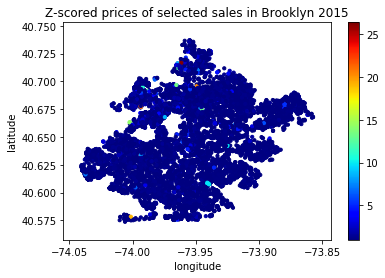

In [15]:
#grab subsslected records and visualize. This will eventually be a geotiff
#and shown in a GIS viewer. currently, Can export info as a csv file and import int QGIS

bktemp = bknew 
#uncomment a subset of points
bktemp = bknew.loc[np.random.randint(1,len(bktemp),10000),:]

pts = 10
prices = np.array(bktemp['SALE PRICE'].tolist())
zscores = stats.zscore(prices) + abs(min(stats.zscore(prices))) + 1
bktemp.plot.scatter('long','lat',c=zscores,cmap='jet',sharex=False,s = pts)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Z-scored prices of selected sales in Brooklyn 2015')
plt.show()

In [6]:
#export prices and lat, long
#bktemp.to_csv('prices_latlong_bk15.csv',columns = ['SALE PRICE','lat','long'])

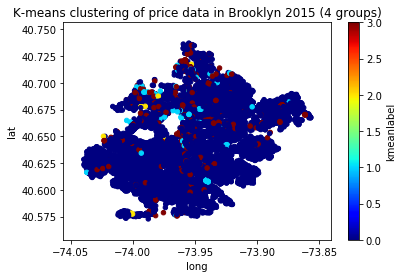

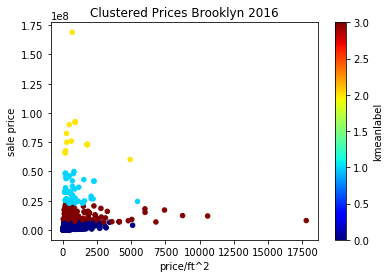

In [16]:
#try a clustering algorithm to group by prices and location

test1 = bknew['SALE PRICE'] > 0.0 
test2 = bknew['GROSS SQUARE FEET'] > 0.0
test3 = ~np.isnan(bknew['SALE PRICE'])
test4 = ~np.isnan(bknew['GROSS SQUARE FEET'])
test = test1 & test2 & test3 & test4

paramlist = ['SALE PRICE','GROSS SQUARE FEET','lat','long']
pd_clean = bknew.loc[test,paramlist]
#calculate price per sq. foot and add to data frame
ppsf = pd_clean['SALE PRICE']/pd_clean['GROSS SQUARE FEET']
pd_clean['ppsf']= ppsf

#k means clustering
params_eval = ['SALE PRICE','GROSS SQUARE FEET','lat','long','ppsf']
pd_eval = pd_clean.loc[:,params_eval]
kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(pd_eval))
pd_eval['kmeanlabel'] = kmeans.labels_
pd_clean['kmeanlabel'] = kmeans.labels_

pts = 20
pd_eval.plot.scatter('long','lat',c='kmeanlabel',cmap='jet',sharex=False,s = pts)
plt.xlabel('long')
plt.ylabel('lat')
plt.title('K-means clustering of price data in Brooklyn 2015 (4 groups)')
plt.show()

pd_clean.plot.scatter('ppsf','SALE PRICE',c='kmeanlabel',cmap='jet',sharex=False, s = pts)
plt.xlabel('price/ft^2')
plt.ylabel('sale price')
plt.title('Clustered Prices Brooklyn 2016')
plt.show()

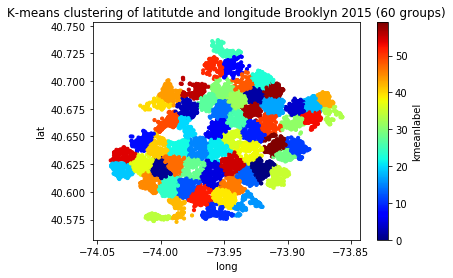

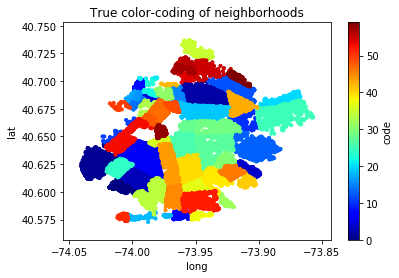

In [17]:
#what if ML made neighborhoods... 
#a clustering approach to partition neighborhoods based on clustering

neighborhoods = bknew.NEIGHBORHOOD.unique()
nn = len(neighborhoods)
#add a code for categorical neighborhoods
bknew['code'] = pd.Categorical(bknew.NEIGHBORHOOD).codes

#k means clustering of lat and long, to make "neighborhoods"
params_eval = ['lat','long']
pd_eval = pd_clean.loc[:,params_eval]
kmeans = KMeans(n_clusters=nn, random_state=0).fit(np.array(pd_eval))
pd_eval['kmeanlabel'] = kmeans.labels_
pd_clean['kmeanlabel'] = kmeans.labels_

pts = 10
pd_eval.plot.scatter('long','lat',c='kmeanlabel',cmap='jet',sharex=False,s = pts)
plt.xlabel('long')
plt.ylabel('lat')
plt.title('K-means clustering of latitutde and longitude Brooklyn 2015 (60 groups)')
plt.show()

#now plot the scatterplot of neighborhoods

bknew.plot.scatter('long','lat',c='code',cmap='jet',sharex=False,s = pts)
plt.xlabel('long')
plt.ylabel('lat')
plt.title('True color-coding of neighborhoods')
plt.show()

In [14]:
#NOT READY run t-sne to visualize the different tax classes and their properties
#remove the lat and long
fname = 'data/2015_brooklyn.csv'
bk = pd.read_csv(fname,sep = ',')
#convert saledate to datetime
bk['SALE DATE'] =pd.to_datetime(bknew['SALE DATE'])


#oldparams = ['BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT',
#          'APARTMENT NUMBER','COMMERCIAL UNITS',
#          'TOTAL UNITS','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','TAX CLASS AT TIME OF SALE',
#          'BUILDING CLASS AT TIME OF SALE','SALE PRICE','SALE DATE']
params = ['TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT',
          'APARTMENT NUMBER','COMMERCIAL UNITS',
          'TOTAL UNITS','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','TAX CLASS AT TIME OF SALE',
          'BUILDING CLASS AT TIME OF SALE','SALE PRICE','SALE DATE']
bk_tsne = bk[params]
#convert categoricals to numbers
bk_tsne['code'] = pd.Categorical(bk.NEIGHBORHOOD).codes
bk_tsne['buildclass'] = pd.Categorical(bk['BUILDING CLASS CATEGORY']).codes


from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(np.array(bk_tsne))
X_embedded.shape


#taken from http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

/Users/dhocker/.conda/envs/nycsales/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dhocker/.conda/envs/nycsales/lib/python3.6/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: could not convert string to float: '1A'

In [8]:
bk_tsne

,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,APARTMENT NUMBER,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,01 ONE FAMILY DWELLINGS,1.0,A5,,0.0,1.0,1547.0,1428.0,1930.0,1.0,A5,758000.0,2015-03-31
1,01 ONE FAMILY DWELLINGS,1.0,A5,,0.0,1.0,1933.0,1660.0,1930.0,1.0,A5,778000.0,2015-06-15
2,01 ONE FAMILY DWELLINGS,1.0,A9,,0.0,1.0,2417.0,2106.0,1930.0,1.0,A9,0.0,2015-09-16
3,01 ONE FAMILY DWELLINGS,1.0,S1,,1.0,2.0,1900.0,2090.0,1931.0,1.0,S1,1365000.0,2015-05-29
4,01 ONE FAMILY DWELLINGS,1.0,A1,,0.0,1.0,2417.0,1672.0,1930.0,1.0,A1,750000.0,2015-12-17
5,01 ONE FAMILY DWELLINGS,1.0,S1,,1.0,2.0,1725.0,2112.0,1925.0,1.0,S1,1470000.0,2015-05-06
6,01 ONE FAMILY DWELLINGS,1.0,S1,,1.0,2.0,1725.0,2112.0,1931.0,1.0,S1,1790000.0,2015-04-30
7,01 ONE FAMILY DWELLINGS,1.0,A1,,0.0,1.0,3625.0,1825.0,1925.0,1.0,A1,820000.0,2015-07-24
8,01 ONE FAMILY DWELLINGS,1.0,S1,,1.0,2.0,1260.0,1440.0,1930.0,1.0,S1,0.0,2015-06-25
9,01 ONE FAMILY DWELLINGS,1.0,S1,,1.0,2.0,1260.0,1440.0,1930.0,1.0,S1,0.0,2015-06-25


array([ 0,  0,  0, ..., 19, 28, 28], dtype=int8)